<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/PVR_dos_Landsat_ANN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8 y 5
* Se usa Keras 2.13 y tensorflow 2.13, para esto se desinstala la actual version 3 - por corregir
* Versión con la estandarizaciíón de datos con StandardScaler
* Clasificación en tres clases (no-urbano, urbano, agua)
* Dos modelos L8 y L5

In [1]:
!pip uninstall tensorflow
!pip3 install tensorflow==2.13

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 25.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing

In [1]:
!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [2]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de datos en formato numpy

In [4]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/PVR_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/PVR_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/PVR_2020_feature_L8_6b.npy')

array_feature_2011 = np.load('/content/drive/MyDrive/Colab Data/PVR_2011_feature_L5_6b.npy')
array_feature_2010 = np.load('/content/drive/MyDrive/Colab Data/PVR_2010_feature_L5_6b.npy')
array_feature_2000 = np.load('/content/drive/MyDrive/Colab Data/PVR_2000_feature_L5_6b.npy')

array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/PVR_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/PVR_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [5]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [6]:
x_features_2020 = feature_transform(array_feature_2020)
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2011 = feature_transform(array_feature_2011)
x_features_2010 = feature_transform(array_feature_2010)
x_features_2000 = feature_transform(array_feature_2000)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 971, 954)
(926334, 6)
(6, 971, 954)
(926334, 6)
(6, 971, 954)
(926334, 6)
(6, 971, 954)
(926334, 6)
(6, 971, 954)
(926334, 6)
(6, 971, 954)
(926334, 6)
(1, 971, 954)
(926334, 1)
(1, 971, 954)
(926334, 1)


Estandarización de datos

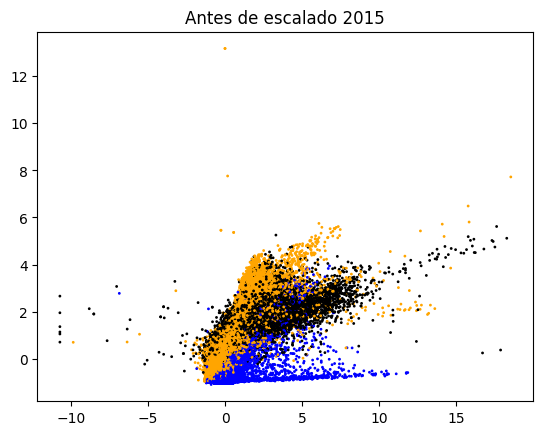

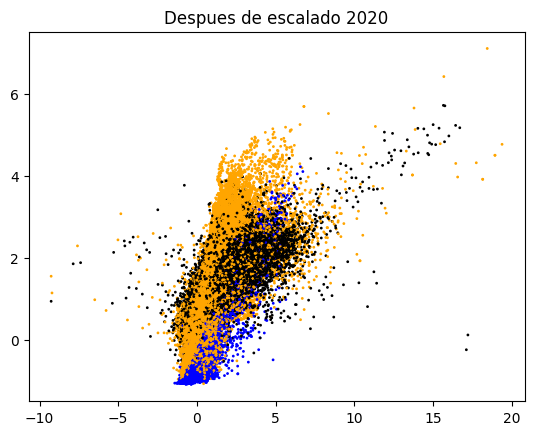

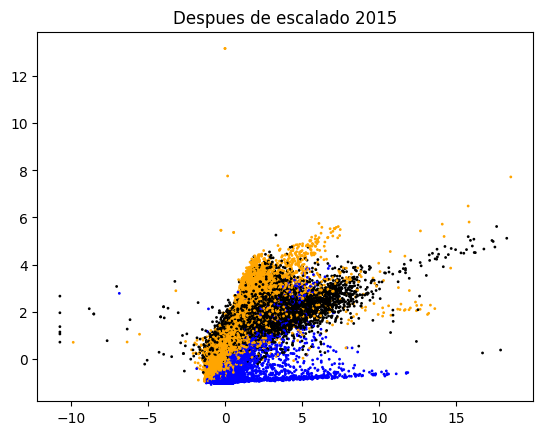

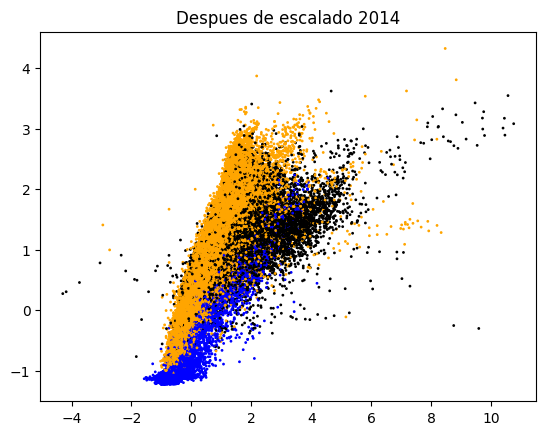

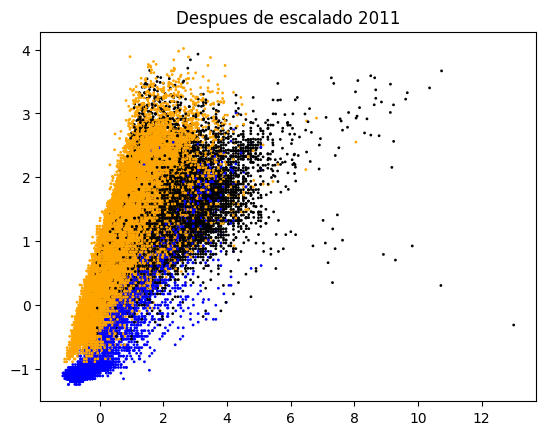

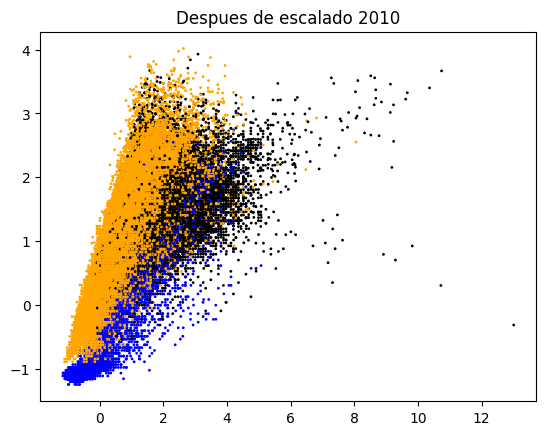

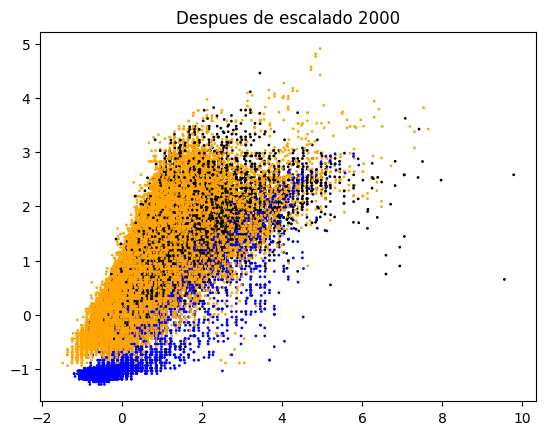

In [9]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(200000,400000)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2020 = scale.fit_transform(x_features_2020)
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2011 = scale.fit_transform(x_features_2011)
x_features_2010 = scale.fit_transform(x_features_2010)
x_features_2000 = scale.fit_transform(x_features_2000)

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2011[rango,0], x_features_2011[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2011')
plt.show()

plt.scatter(x_features_2010[rango,0], x_features_2010[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2010')
plt.show()

plt.scatter(x_features_2000[rango,0], x_features_2000[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2000')
plt.show()

In [10]:
print(x_features_2015)
print(y_labels_2015)

[[-1.06118468 -0.72865397 -0.61170484  0.05326535 -0.58884984 -0.66031471]
 [-1.01833991 -0.70423191 -0.5798884   0.02548718 -0.44472317 -0.55964309]
 [-1.01960005 -0.70591619 -0.58179738  0.04204371 -0.33061162 -0.50211645]
 ...
 [-0.55208797 -0.24358152 -0.17963751  0.57718732  0.57552059  0.14226182]
 [-0.34542495 -0.16610467 -0.04091781  0.58362597  0.70234125  0.34640149]
 [-0.88602517 -0.66296707 -0.46025856 -0.12775264 -0.12023536 -0.20090057]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


Subdividir datos de entrenamiento y control (2015)

In [11]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.4, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(555800, 6)
(555800, 1)
(370534, 6)
(370534, 1)
[[-0.18916754 -0.57033171 -0.78860428 -1.32092605 -1.24269278 -1.03463736]
 [ 1.41121073  1.26384849  1.62880925  0.43057011  1.37916875  1.67510707]
 [-0.75875099 -0.47601207 -0.4545316   0.20190613 -0.1429495  -0.30396913]
 ...
 [-0.37314804  0.10253789  0.04116862  0.76243641  0.53279637  0.3080504 ]
 [-0.31770186 -0.88950264 -0.82678401 -1.30455349 -1.23431018 -1.03463736]
 [-0.14128221 -0.01115097 -0.08736982  0.93922329  0.63041312  0.23853904]]
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]
(555800, 1, 6) (370534, 1, 6)


Entrenar la red neuronal (ANN) simple con 2 capas ocultas

In [14]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=10)

Epoch 1/10
17369/17369 [==============================] - 44s 2ms/step - loss: 0.1491 - accuracy: 0.9427
Epoch 2/10
17369/17369 [==============================] - 39s 2ms/step - loss: 0.1283 - accuracy: 0.9493
Epoch 3/10
17369/17369 [==============================] - 37s 2ms/step - loss: 0.1250 - accuracy: 0.9505
Epoch 4/10
17369/17369 [==============================] - 39s 2ms/step - loss: 0.1233 - accuracy: 0.9511
Epoch 5/10
17369/17369 [==============================] - 37s 2ms/step - loss: 0.1222 - accuracy: 0.9516
Epoch 6/10
17369/17369 [==============================] - 38s 2ms/step - loss: 0.1213 - accuracy: 0.9519
Epoch 7/10
17369/17369 [==============================] - 38s 2ms/step - loss: 0.1209 - accuracy: 0.9521
Epoch 8/10
17369/17369 [==============================] - 36s 2ms/step - loss: 0.1204 - accuracy: 0.9524
Epoch 9/10
17369/17369 [==============================] - 38s 2ms/step - loss: 0.1202 - accuracy: 0.9524
Epoch 10/10
17369/17369 [==============================

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [15]:
model.save('/content/drive/MyDrive/Colab Data/PVR_2015_model_ANN_2hl_3class.tensorflow')

In [16]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

11580/11580 [==============================] - 18s 2ms/step


In [17]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[208928    377   6021]
 [   428 122359    700]
 [ 10062    182  21477]]

Exactitud (accuracy): 0.952,

Kappa de Cohen: 0.911,

Clase 1. Selectividad (precision): 0.952, especificidad (recall): 0.970, f1: 0.961

Clase 2. Selectividad (precision): 0.995, especificidad (recall): 0.991, f1: 0.993

Clase 3. Selectividad (precision): 0.762, especificidad (recall): 0.677, f1: 0.717


Predicción para datos de 2015

In [18]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

28948/28948 [==============================] - 46s 2ms/step
[[9.3343604e-01 6.1741821e-02 4.8220418e-03]
 [9.9054062e-01 7.2377361e-03 2.2217247e-03]
 [9.9845368e-01 7.4499618e-04 8.0133142e-04]
 ...
 [9.9972802e-01 3.2567507e-07 2.7164177e-04]
 [9.9943990e-01 1.4878215e-07 5.5993494e-04]
 [9.9337387e-01 9.6511876e-06 6.6164536e-03]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


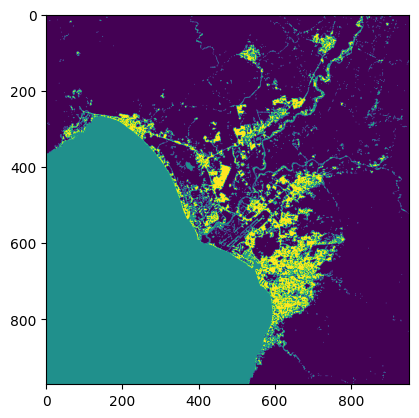

In [19]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
print(predicted_2015_class.reshape(x_features_2015_n.shape[0], 1))
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

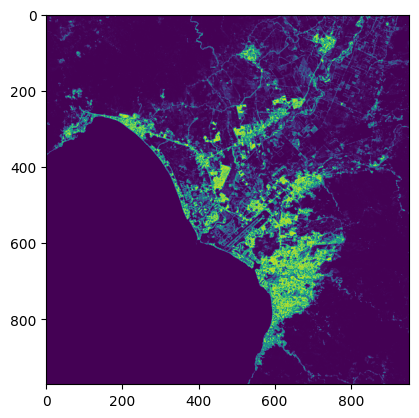

In [20]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [21]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

28948/28948 [==============================] - 52s 2ms/step
[[9.7868192e-01 2.4602406e-03 1.8857786e-02]
 [9.8605675e-01 1.1529045e-03 1.2790299e-02]
 [9.9500942e-01 2.8104859e-04 4.7094868e-03]
 ...
 [9.9798238e-01 1.0749671e-05 2.0069026e-03]
 [9.9967420e-01 3.2806273e-07 3.2544474e-04]
 [9.9926299e-01 6.7726762e-07 7.3628308e-04]]


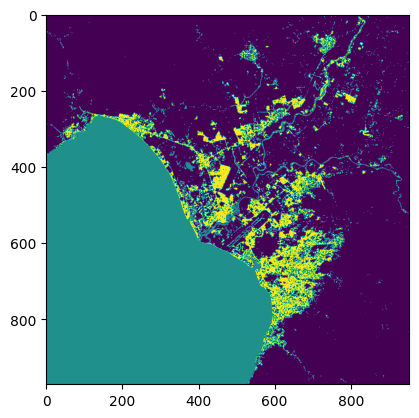

In [22]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

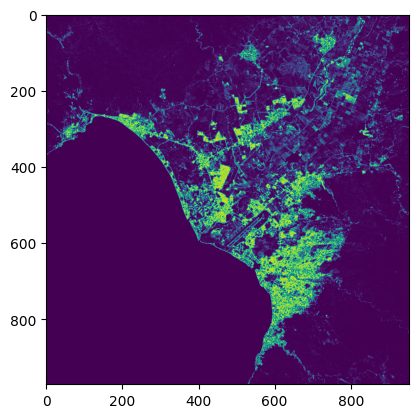

In [23]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [24]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

28948/28948 [==============================] - 69s 2ms/step
[[9.9171948e-01 3.4416973e-04 7.9363883e-03]
 [9.9443859e-01 2.2333594e-04 5.3381580e-03]
 [9.9237651e-01 6.8837783e-04 6.9350828e-03]
 ...
 [9.9298072e-01 8.4422460e-09 7.0192423e-03]
 [9.9270308e-01 1.0585664e-08 7.2969249e-03]
 [9.9300283e-01 2.5297261e-06 6.9946507e-03]]


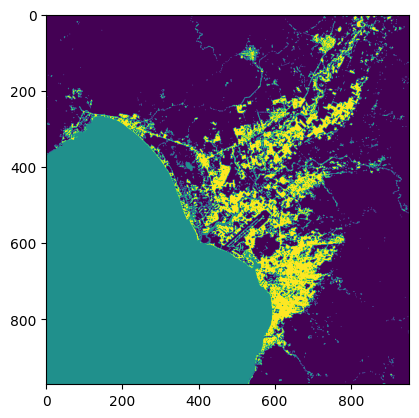

In [25]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

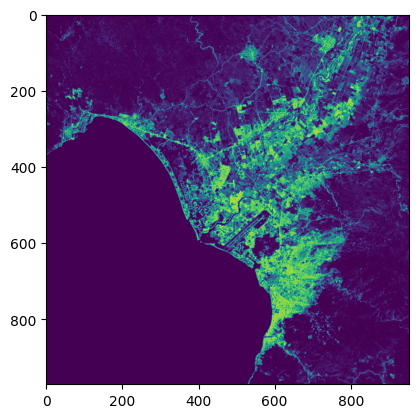

In [26]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [27]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/PVR_2014_prediction_class.npy', predicted_2014_class)
np.save('/content/drive/MyDrive/Colab Data/PVR_2015_prediction_class.npy', predicted_2015_class)
np.save('/content/drive/MyDrive/Colab Data/PVR_2020_prediction_class.npy', predicted_2020_class)
np.save('/content/drive/MyDrive/Colab Data/PVR_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/PVR_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/PVR_2020_prediction_urbano_float.npy', prediction_2020_urbano)

In [30]:
x_features_2011_n = x_features_2011
x_features_2011_n = x_features_2011_n.reshape((x_features_2011_n.shape[0], 1, x_features_2011_n.shape[1]))

y_target_2011_n = predicted_2015_class.reshape(x_features_2015_n.shape[0], 1)

print(x_features_2011_n.shape, y_target_2011_n.shape)

# Define the parameters of the model
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model1.fit(x_features_2011_n, y_target_2011_n, epochs=10)

(926334, 1, 6) (926334, 1)
Epoch 1/10
28948/28948 [==============================] - 72s 2ms/step - loss: 0.1193 - accuracy: 0.9571
Epoch 2/10
28948/28948 [==============================] - 66s 2ms/step - loss: 0.1075 - accuracy: 0.9611
Epoch 3/10
28948/28948 [==============================] - 66s 2ms/step - loss: 0.1059 - accuracy: 0.9614
Epoch 4/10
28948/28948 [==============================] - 67s 2ms/step - loss: 0.1049 - accuracy: 0.9616
Epoch 5/10
28948/28948 [==============================] - 65s 2ms/step - loss: 0.1044 - accuracy: 0.9617
Epoch 6/10
28948/28948 [==============================] - 65s 2ms/step - loss: 0.1042 - accuracy: 0.9618
Epoch 7/10
28948/28948 [==============================] - 66s 2ms/step - loss: 0.1039 - accuracy: 0.9619
Epoch 8/10
28948/28948 [==============================] - 67s 2ms/step - loss: 0.1037 - accuracy: 0.9620
Epoch 9/10
28948/28948 [==============================] - 65s 2ms/step - loss: 0.1037 - accuracy: 0.9619
Epoch 10/10
28948/28948 [===

In [31]:
model1.save('/content/drive/MyDrive/Colab Data/PVR_2011_model_ANN_2hl_3class.tensorflow')

In [32]:
x_features_2010_n = x_features_2010
x_features_2010_n = x_features_2010_n.reshape((x_features_2010_n.shape[0], 1, x_features_2010_n.shape[1]))

predicted_2010 = model.predict(x_features_2010_n)
print(predicted_2010)

28948/28948 [==============================] - 47s 2ms/step
[[9.94348228e-01 9.57951182e-04 4.69373073e-03]
 [9.86618102e-01 5.72597019e-05 1.33246295e-02]
 [9.98203099e-01 1.25946040e-04 1.67104357e-03]
 ...
 [9.98898029e-01 3.96484126e-08 1.10190909e-03]
 [9.98293459e-01 2.10998834e-07 1.70626130e-03]
 [9.94709492e-01 3.56338205e-05 5.25485910e-03]]


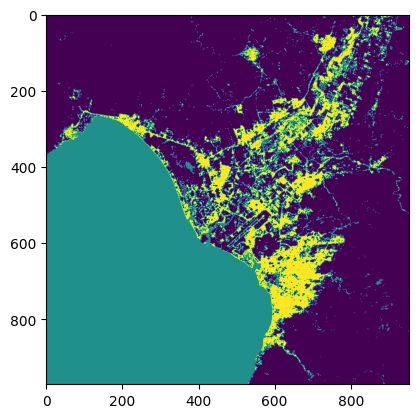

In [33]:
predicted_2010_class = predicted_2010.argmax(axis=-1)
predicted_2010_class_re = np.reshape(predicted_2010_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2010_class_re[:,:])
plt.show()

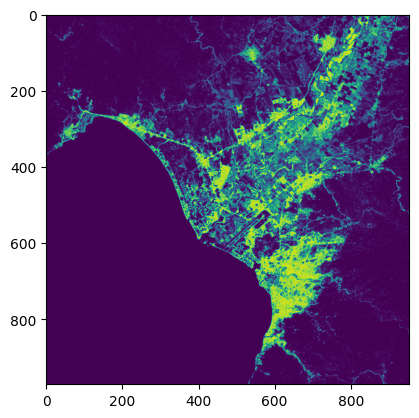

In [34]:
prediction_2010_urbano = np.reshape(predicted_2010[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2010 = (prediction_2010_urbano).astype('float')
plt.imshow(B_img_pred_2010[:,:])
plt.show()

In [35]:
x_features_2000_n = x_features_2000
x_features_2000_n = x_features_2000_n.reshape((x_features_2000_n.shape[0], 1, x_features_2000_n.shape[1]))

predicted_2000 = model.predict(x_features_2000_n)
print(predicted_2000)

28948/28948 [==============================] - 127s 4ms/step
[[9.9947518e-01 1.2556316e-06 5.2343484e-04]
 [9.9990326e-01 2.0989593e-05 7.5648881e-05]
 [9.9965811e-01 6.5143900e-07 3.4127859e-04]
 ...
 [9.9466813e-01 8.9789057e-07 5.3309463e-03]
 [9.4808620e-01 5.9382610e-06 5.1907789e-02]
 [9.8787284e-01 1.1888947e-06 1.2126032e-02]]


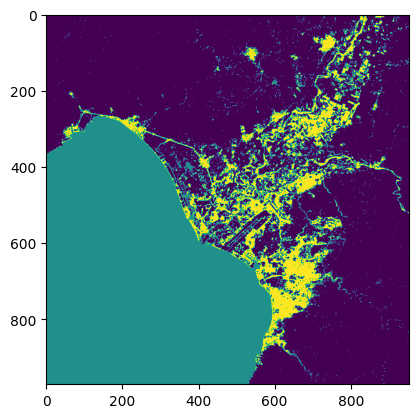

In [36]:
predicted_2000_class = predicted_2000.argmax(axis=-1)
predicted_2000_class_re = np.reshape(predicted_2000_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2000_class_re[:,:])
plt.show()

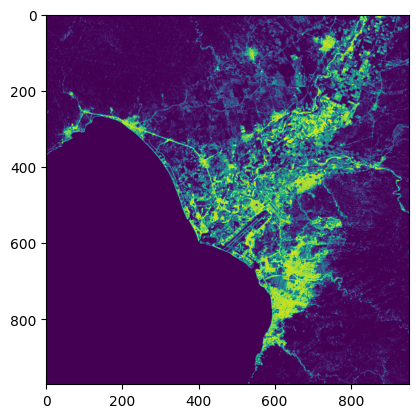

In [37]:
prediction_2000_urbano = np.reshape(predicted_2000[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2000 = (prediction_2000_urbano).astype('float')
plt.imshow(B_img_pred_2000[:,:])
plt.show()

In [38]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/PVR_2010_prediction_class.npy', predicted_2010_class)
np.save('/content/drive/MyDrive/Colab Data/PVR_2000_prediction_class.npy', predicted_2000_class)
np.save('/content/drive/MyDrive/Colab Data/PVR_2010_prediction_urbano_float.npy', prediction_2010_urbano)
np.save('/content/drive/MyDrive/Colab Data/PVR_2000_prediction_urbano_float.npy', prediction_2000_urbano)